## Ensemble Methods

- ensemble estimate: $\bar{y} = \frac{1}{K} \sum_{k=1}^K \hat{y}_k$
- squared error of the ensemble estimate: $\left(\bar{y} - y\right)^2$
- decomposition into an accuracy and diversity term: $\left(\bar{y} - y\right)^2 = \frac{1}{K} \sum_{k=1}^K (\hat{y}_k - y)^2 - \frac{1}{K}\sum_{k=1}^K (\hat{y}_k - \bar{y})^2$
- the ensemble will work well, if the members are diverse and individually accurate

<img src="../_img/ensemble.jpg" width="350px" align="left">

## Random Forest

[Random forest](https://en.wikipedia.org/wiki/Random_forest) is a tree based algorithm for classification and regression. It can be viewed as a "parallel circuit" of decision trees. The output of the forest is the average output of its trees. Some methods to grow an accurate and diverse set of trees are as follows:

- [Bootstrapping](https://en.wikipedia.org/wiki/Bootstrap_aggregating): Each tree is trained on a data set that was sampled from the original data with replacement.


- [Feature bagging](https://en.wikipedia.org/wiki/Random_subspace_method): Each tree is trained on a random subset of the features.


- [Extreme randomization](https://en.wikipedia.org/wiki/Random_forest#ExtraTrees): For each feature, a random split value is used instead of the optimal one.

**Exercise 1**: Implement a bootstrapping based random forest regressor and evaluate it on the Boston Housing data set using 3-fold cross-validation! The evaluation metric should be RMSE!

In [38]:
# Load the data to DataFrame.
import pandas as pd
names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
         'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT', 'MEDV']
df = pd.read_csv('../_data/housing_data.txt', delim_whitespace=True, names=names)
df = df.sample(len(df), random_state=42) # shuffle the data
X = df[df.columns[:-1]].values           # input matrix
y = df['MEDV'].values                    # target vector

In [39]:
X.shape, y.shape

((506, 12), (506,))

In [40]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor


class SimpleRandomForest:
    def __init__(self, n_trees=100):
        self.n_trees = n_trees
    
    def fit(self, X, y):
        n = X.shape[0]
        rs = np.random.RandomState(42)
        
        self.trees = []
        for k in range(self.n_trees):
            idxs = rs.randint(n, size=n)
            tree = DecisionTreeRegressor(random_state=42)
            tree.fit(X[idxs], y[idxs]) # train tree on bootstrap sample
            self.trees.append(tree)
            
    def predict(self, X):
        yhat = np.zeros(X.shape[0])
        for tree in self.trees:
            yhat += tree.predict(X)
        yhat /= len(self.trees)
        return yhat
            

In [41]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def evaluate(re, X, y):
    cv = KFold(3, shuffle=True, random_state=42)
    scores = []
    for tr, te in cv.split(X):
        re.fit(X[tr], y[tr])
        yhat = re.predict(X)
        score = mean_squared_error(y[te], yhat[te])**0.5
        scores.append(score)
    return np.mean(scores)

In [42]:
evaluate(SimpleRandomForest(), X, y)

3.562571926543196

In [43]:
evaluate(DecisionTreeRegressor(random_state=42), X, y)

4.867211481330203

In [44]:
from sklearn.linear_model import Ridge
evaluate(Ridge(), X, y)

4.927289718141437

**Exercise 2**: Implement a feature bagging based random forest regressor and evaluate it on the Boston Housing data set using 3-fold cross-validation!

Feature bagging strategy: We select a random 50% of the columns without replacement.

In [45]:
from numpy import random
import numpy as np
from sklearn.tree import DecisionTreeRegressor

class SimpleRandomForest:
    def __init__(self, n_trees=100, bootstrap=True, feature_bagging=False):
        self.n_trees = n_trees
        self.bootstrap = bootstrap
        self.feature_bagging = feature_bagging
        
    def fit(self, X, y):
        n, d = X.shape
        rs = np.random.RandomState(42)
        
        self.trees = []
        for k in range(self.n_trees):
            X2, y2 = X, y
            cols = np.arange(d)
            if self.bootstrap:
                idxs = rs.randint(n, size=n) # sample rows
                X2, y2 = X2[idxs], y2[idxs]
            if self.feature_bagging:
                cols = rs.permutation(d)[:d // 2] # sample columns
                X2 = X2[:, cols]
                
            tree = DecisionTreeRegressor(random_state=42)
            tree.fit(X2, y2)
            self.trees.append((tree, cols))
            
    def predict(self, X):
        yhat = np.zeros(X.shape[0])
        for tree, cols in self.trees:
            yhat += tree.predict(X[:, cols])
        yhat /= len(self.trees)
        return yhat

In [46]:
# bootstrapping
evaluate(SimpleRandomForest(), X, y)

3.562571926543196

In [47]:
# feature bagging
evaluate(SimpleRandomForest(bootstrap=False, feature_bagging=True), X, y)

3.857511376178318

In [48]:
# bootstrapping + feature bagging
evaluate(SimpleRandomForest(bootstrap=True, feature_bagging=True), X, y)

3.8680728197805725

**Exercise 3**: Repeat the previous experiments using scikit-learn's RandomForestRegressor class!

In [49]:
from sklearn.ensemble import RandomForestRegressor

evaluate(RandomForestRegressor(random_state=42), X, y)

3.578281219483339

In [50]:
evaluate(RandomForestRegressor(random_state=42, bootstrap=False, max_features=.5), X, y)

3.432009311114937

In [51]:
evaluate(RandomForestRegressor(random_state=42, max_features=.5), X, y)

3.464869293320867

**Exercise 4**: Plot the training and the test RMSE as a function of the number of trees!

In [52]:
def evaluate(re, X, y):
    cv = KFold(3, shuffle=True, random_state=42)
    scores_tr, scores_te = [], []
    for tr, te in cv.split(X):
        re.fit(X[tr], y[tr])
        yhat = re.predict(X)
        scores_tr.append(mean_squared_error(y[tr], yhat[tr])**0.5)
        scores_te.append(mean_squared_error(y[te], yhat[te])**0.5)        
    return {'rmse_tr': np.mean(scores_tr), 'rmse_te': np.mean(scores_te)}

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 

<AxesSubplot: xlabel='n_estimators'>

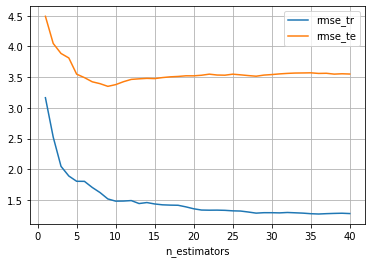

In [53]:
res = []
for n_estimators in range(1, 41):
    print(n_estimators, end=' ')
    re = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    r = evaluate(re, X, y)
    r['n_estimators'] = n_estimators
    res.append(r)
pd.DataFrame(res).set_index('n_estimators').plot(grid=True)

**Exercise 5**: Repeat the previous experiment using the "extreme randomization" strategy!

- extreme randomization:
    + for each feature select random split value (between the minimal ad maximal feature value)
    + select the split that gives the lowest error

In [54]:
from sklearn.ensemble import ExtraTreesRegressor

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 

<AxesSubplot: xlabel='n_estimators'>

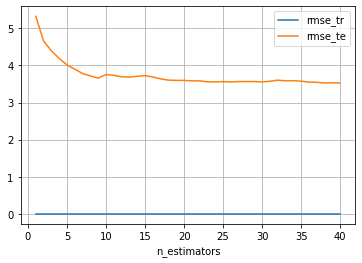

In [59]:
res = []
for n_estimators in range(1, 41):
    print(n_estimators, end=' ')
    re = ExtraTreesRegressor(n_estimators=n_estimators, random_state=42)
    r = evaluate(re, X, y)
    r['n_estimators'] = n_estimators
    res.append(r)
pd.DataFrame(res).set_index('n_estimators').plot(grid=True)